Installing necessary package

In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
!pip install opencv-python

### Import the packages

In [3]:
import ultralytics
print(ultralytics.__version__)

8.2.2


In [4]:
import os
import cv2
import glob
from typing import Dict
import yaml
import random
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
from PIL import Image
from google.colab import drive
from matplotlib import pyplot as plt

### Get the Dataset From Kaggle
 This Dataset is chosen because:

In [5]:
!unzip css-data.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: css-data/train/labels/IMG_3100_mp4-0_jpg.rf.8e364de5178639165a16329b5c1b0f82.txt  
  inflating: __MACOSX/css-data/train/labels/._IMG_3100_mp4-0_jpg.rf.8e364de5178639165a16329b5c1b0f82.txt  
  inflating: css-data/train/labels/construction-4-_mp4-41_jpg.rf.ab0b49bfa0036086c3d484b988e99934.txt  
  inflating: __MACOSX/css-data/train/labels/._construction-4-_mp4-41_jpg.rf.ab0b49bfa0036086c3d484b988e99934.txt  
  inflating: css-data/train/labels/construction-3-_mp4-162_jpg.rf.7c643844819ddd3253bfdbe453045403.txt  
  inflating: __MACOSX/css-data/train/labels/._construction-3-_mp4-162_jpg.rf.7c643844819ddd3253bfdbe453045403.txt  
  inflating: css-data/train/labels/youtube-396_jpg.rf.4f572c63abb01bb67be5e300f0f0f34c.txt  
  inflating: __MACOSX/css-data/train/labels/._youtube-396_jpg.rf.4f572c63abb01bb67be5e300f0f0f34c.txt  
  inflating: css-data/train/labels/2008_008444_jpg.rf.429b802dc2a4bb0171d0b296fcb04454.txt  
  inflat

In [6]:
DATASET_DIR = "/content/css-data"
OUTPUT_DIR = "/content/"
IMAGE_PATH = "/content/css-data/train/images/construction-986-_jpg.rf.3ecb527ce78e89716a17826e5d05f682.jpg"
CLASSES = [
    'Hardhat',
    'Mask',
    'Gloves'
    'Goggles'
    'No-Goggles'
    'No-Hardhat',
    'No-Mask',
    'No-Safety Vest',
    'Person',
    'Safety Cone',
    'Safety Vest',
    'Safety Shoes',
    'No-Safety Shoes'
    'machinery',
    'vehicle'
]
NUM_CLASSES = len(CLASSES)
EPOCHS = 80
BATCH_SIZE = 16
OPTIMIZER = 'auto'
LEARNING_RATE = 1e-3
LR_FACTOR = 0.01
WEIGHT_DECAY = 5e-4
FRACTION = 1.0
PATIENCE = 20
SEED = 88
PROFILE = False
BASE_MODEL = 'yolov8n'
MODEL_WEIGHT = f"{BASE_MODEL}.pt"
EXP_NAME = f"ppe_css_{BASE_MODEL}_epochs"


### Create YAML File and Read it

In [7]:
# Create yaml file
dict_file = {
    'train': os.path.join(DATASET_DIR, 'train'),
    'val': os.path.join(DATASET_DIR, 'valid'),
    'test': os.path.join(DATASET_DIR, 'test'),
    'nc': NUM_CLASSES,
    'names': CLASSES
}

with open(os.path.join(OUTPUT_DIR, 'data.yaml'), 'w+') as file:
  yaml.dump(dict_file, file)

In [8]:
# Read yaml file
def read_yaml(file_path: Path) -> Dict:
  with open(file_path, 'rb') as file:
    try:
      data = yaml.safe_load(file)
      return data
    except yaml.YAMLError as e:
      print(f"Yaml File Error: {e}")
      return None

file_path = os.path.join(OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml(file_path)
if yaml_data:
  formatted_yaml = yaml.dump(yaml_data, default_style=False)
  print(formatted_yaml)

names:
- Hardhat
- Mask
- GlovesGogglesNo-GogglesNo-Hardhat
- No-Mask
- No-Safety Vest
- Person
- Safety Cone
- Safety Vest
- Safety Shoes
- No-Safety Shoesmachinery
- vehicle
nc: 11
test: /content/css-data/test
train: /content/css-data/train
val: /content/css-data/valid



### Exploratory Data Analysis

In [9]:
def show_image(image_path: Path = None, folder_path: Path = None, random_img: bool = True, num_imgs: int = 2) -> None:
  if random_img:
    pass
    image_files = [i for i in os.listdir(folder_path) if i.endswith(('jpg', 'png', 'jpeg', 'gif'))]
    if len(image_files) < num_imgs:
      raise ValueError("Images is not enough. Try another folder path")
    selected_imgs = random.sample(image_files, num_imgs)

    num_cols = 5
    num_rows = (num_imgs + num_cols -1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    for i, file_name in enumerate(selected_imgs):
      img = Image.open(os.path.join(folder_path, file_name))
      if num_rows == 1:
        ax = axes[i % num_cols]
      else:
        ax = axes[i // num_cols, i % num_cols]
      ax.imshow(img)
      ax.axis('off')
    for i in range(num_imgs, num_rows * num_cols):
      if num_rows == 1:
        fig.delaxes(axes[i % num_cols])
      else:
        fig.delaxes(axes[i // num_cols, i % num_cols])
    plt.tight_layout()
    plt.show()

  else:
    plt.figure(figsize=(10, 10))
    if isinstance(image_path, str):
      img = Image.open(image_path)
      plt.imshow(img)
    elif isinstance(image_path, np.ndarray):
      image = image_path[..., ::-1]
      img = Image.fromarray(image)
      plt.imshow(img)
    else:
      raise ValueError("Unsupported image format")
    print(f"Type: {type(img)} \n")
    print(f"Shape: {np.array(img).shape}")
    plt.show()

Type: <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape: (640, 640, 3)


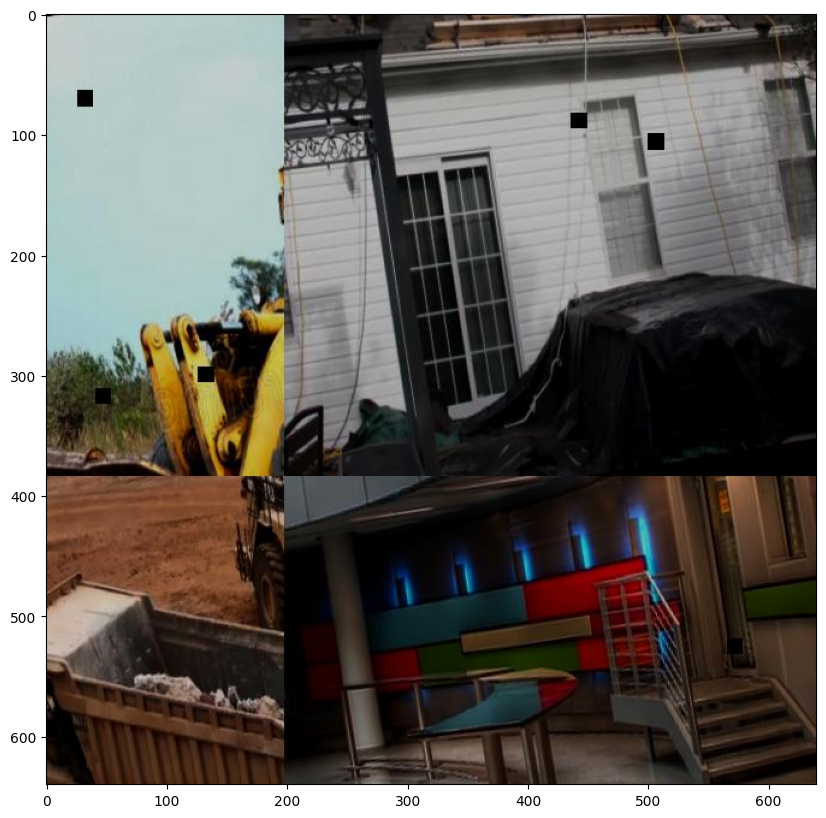

In [10]:
show_image(image_path=IMAGE_PATH, random_img=False)

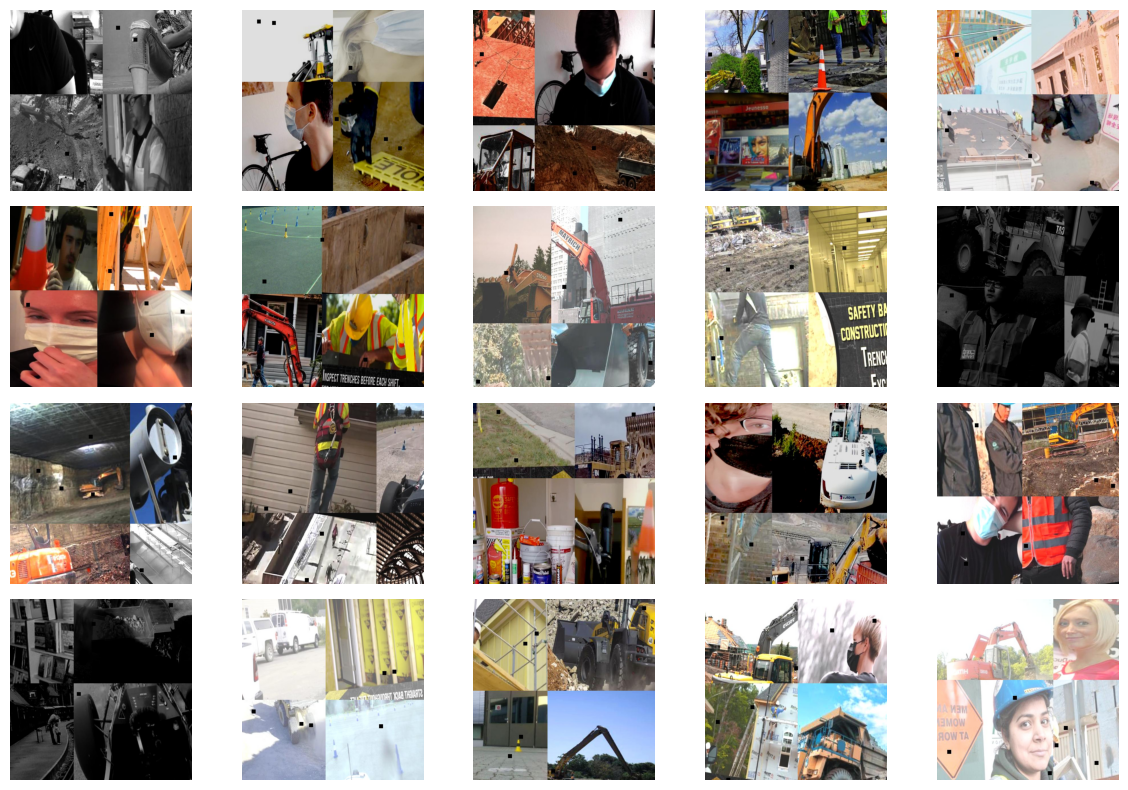

In [11]:
folder_path = DATASET_DIR + '/train/images/'
show_image(folder_path=folder_path, num_imgs=20)

#### Get Image Properties

In [12]:
def image_properties(image_path: Path) -> Dict:
  properties = {}
  img = cv2.imread(image_path)
  if img is None:
    raise ValueError("Image is not exist")
  properties = {
      "width": img.shape[1],
      "height": img.shape[0],
      "channels": img.shape[2] if len(img.shape) == 3 else 1,
      "dtype": img.dtype
  }
  return properties

In [13]:
img_properties = image_properties(IMAGE_PATH)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

#### Image Statistic

In [14]:
%%time
class_idx = {str(i): CLASSES[i] for i in range(NUM_CLASSES)}
class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
  class_count = {CLASSES[i]: 0 for i in range(NUM_CLASSES)}
  path = os.path.join(DATASET_DIR, mode, 'labels')
  for file in os.listdir(path):
    with open(os.path.join(path, file)) as f:
      lines = f.readlines()
      for cls in set([line[0] for line in lines]):
        class_count[class_idx[cls]] += 1
  data_len[mode] = len(os.listdir(path))
  class_stat[mode] = class_count
  class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})
  dataset_stats = pd.DataFrame(class_info)
  dataset_stats

CPU times: user 78 ms, sys: 65.5 ms, total: 144 ms
Wall time: 354 ms


In [15]:
dataset_stats

Mode  Hardhat  Mask  GlovesGogglesNo-GogglesNo-Hardhat  No-Mask  \
0  train     1314  1096                               1380     1531   
1  valid       42    19                                 37       44   
2   test       30    16                                 25       30   

   No-Safety Vest  Person  Safety Cone  Safety Vest  Safety Shoes  \
0            1864    2526          631         1319          2101   
1              56      84           13           28            26   
2              36      59            8           22            22   

   No-Safety Shoesmachinery  vehicle  Data_Volume  
0                       744        0         2605  
1                        16        0          114  
2                        15        0           82

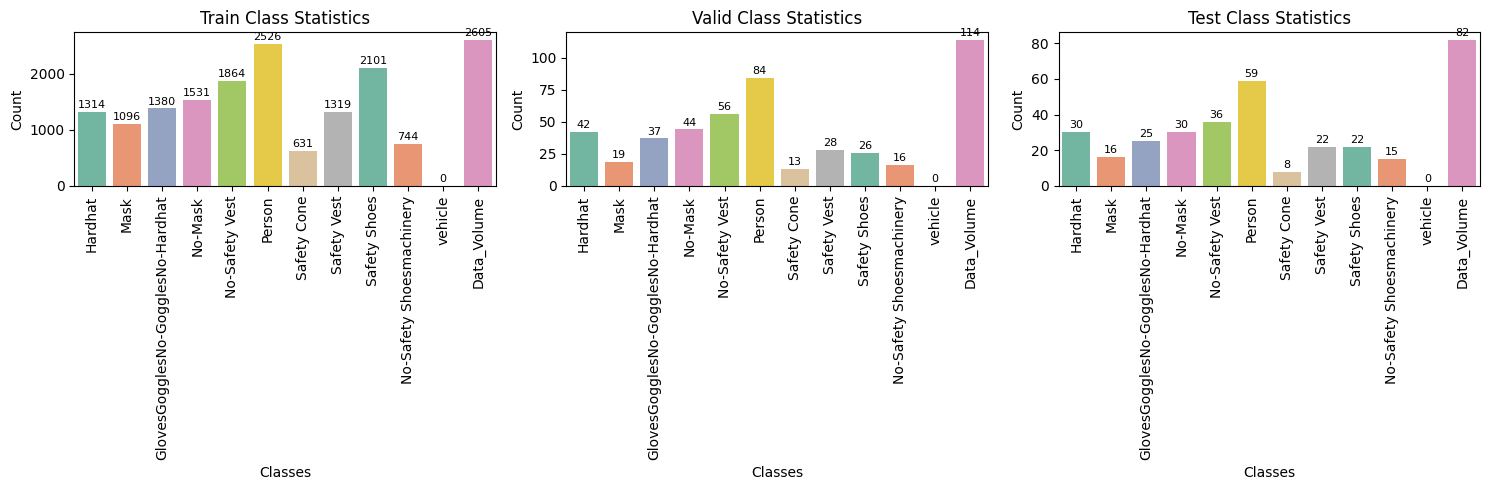

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, mode in enumerate(['train', 'valid', 'test']):
  sns.barplot(
      data=dataset_stats[dataset_stats['Mode'] == mode].drop(columns='Mode'),
      orient='v',
      ax=axes[i],
      palette='Set2'
  )
  axes[i].set_title(f"{mode.capitalize()} Class Statistics")
  axes[i].set_xlabel('Classes')
  axes[i].set_ylabel('Count')
  axes[i].tick_params(axis='x', rotation=90)

  for p in axes[i].patches:
    axes[i].annotate(f"{int(p.get_height())}",
                     (p.get_x() + p.get_width() / 2, p.get_height()),
                     ha='center',
                     va='center',
                     fontsize=8,
                     color='black',
                     xytext=(0, 5),
                     textcoords='offset points')
plt.tight_layout()
plt.show()

In [17]:
%%time
for mode in ['train', 'valid', 'test']:
  print(f"Image size in {mode} set: ")
  img_size = 0
  for file in glob.glob(os.path.join(DATASET_DIR, mode, 'images', '*')):
    image = Image.open(file)
    if image.size != img_size:
      print(image.size)
      img_size = image.size

Image size in train set: 
(640, 640)
Image size in valid set: 
(640, 640)
Image size in test set: 
(640, 640)
CPU times: user 320 ms, sys: 62.3 ms, total: 382 ms
Wall time: 467 ms


In [18]:
MODEL = YOLO(MODEL_WEIGHT)
results = MODEL.predict(
    source = IMAGE_PATH,
    classes = [0],
    conf = 0.30,
    imgsz = (img_properties['height'], img_properties['width']),
    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

100%|██████████| 6.23M/6.23M [00:00<00:00, 66.1MB/s]



image 1/1 /content/css-data/train/images/construction-986-_jpg.rf.3ecb527ce78e89716a17826e5d05f682.jpg: 640x640 (no detections), 26.2ms
Speed: 6.2ms preprocess, 26.2ms inference, 4737.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
0 label saved to runs/detect/predict/labels


Type: <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape: (640, 640, 3)


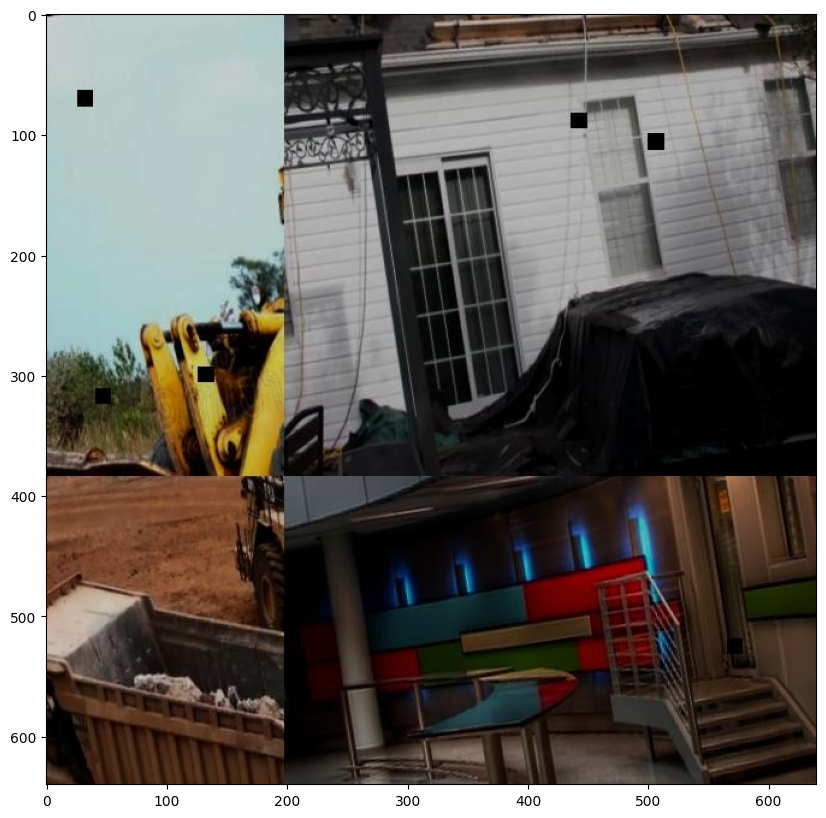

In [19]:
example_image = IMAGE_PATH.split('/')[-1]
show_image(image_path=f"/content/runs/detect/predict/{example_image}", random_img=False)

In [20]:
MODEL = YOLO(MODEL_WEIGHT)
MODEL.train(
    data=os.path.join(OUTPUT_DIR, 'data.yaml'),
    task='detect',
    imgsz=(img_properties['height'], img_properties['width']),
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    optimizer=OPTIMIZER,
    lr0=LEARNING_RATE,
    lrf=LR_FACTOR,
    weight_decay=WEIGHT_DECAY,
    fraction=FRACTION,
    patience=PATIENCE,
    profile=PROFILE,
    name=f"{BASE_MODEL}_{EXP_NAME}",
    seed=SEED,
    val=True,
    amp=True,
    exist_ok=True,
    resume=False,
    verbose=False
)

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=80, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_ppe_css_yolov8n_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

100%|██████████| 755k/755k [00:00<00:00, 18.8MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:01<00:00, 1973.63it/s]

train: WARNING ⚠️ /content/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: New cache created: /content/css-data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 1496.82it/s]

val: New cache created: /content/css-data/valid/labels.cache


Plotting labels to runs/detect/yolov8n_ppe_css_yolov8n_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_ppe_css_yolov8n_epochs
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      3.12G      1.403      2.923      1.486        346        640: 100%|██████████| 163/163 [01:13<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        114        697      0.445      0.385      0.359      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      3.09G      1.298      1.873      1.437        275        640: 100%|██████████| 163/163 [01:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        114        697      0.496      0.389       0.37      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      2.93G      1.266      1.685      1.413        266        640: 100%|██████████| 163/163 [01:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        114        697      0.672      0.461      0.509      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      3.69G      1.238      1.589      1.387        288        640: 100%|██████████| 163/163 [01:02<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        114        697      0.651      0.491       0.54      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      2.99G      1.207      1.506      1.362        315        640: 100%|██████████| 163/163 [01:02<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        114        697      0.633      0.493      0.533      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      3.66G      1.195      1.464      1.352        284        640: 100%|██████████| 163/163 [01:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        114        697      0.672      0.536       0.58      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      3.33G      1.174      1.398      1.329        301        640: 100%|██████████| 163/163 [01:02<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        114        697       0.72      0.519       0.59      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      2.78G      1.149       1.36      1.319        244        640: 100%|██████████| 163/163 [01:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        114        697      0.695      0.532      0.593      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      3.07G      1.147      1.333      1.314        277        640: 100%|██████████| 163/163 [01:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        114        697       0.69      0.602      0.636      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      2.95G      1.125      1.279      1.296        267        640: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        114        697      0.753      0.548      0.612      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      3.06G       1.11      1.242      1.287        270        640: 100%|██████████| 163/163 [01:02<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all        114        697       0.73      0.564      0.628      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      2.73G      1.102      1.217      1.278        311        640: 100%|██████████| 163/163 [01:04<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        114        697      0.696      0.609      0.644      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      2.98G      1.085      1.179      1.272        316        640: 100%|██████████| 163/163 [01:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        114        697      0.749       0.58      0.646      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      2.97G      1.091      1.168      1.271        240        640: 100%|██████████| 163/163 [01:04<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


                   all        114        697      0.778      0.618      0.669      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      3.03G      1.076      1.151      1.256        245        640: 100%|██████████| 163/163 [01:03<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        114        697      0.734      0.601      0.649      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80       3.3G      1.073      1.132      1.255        251        640: 100%|██████████| 163/163 [01:04<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        114        697      0.762      0.585      0.644      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      3.01G      1.054      1.102       1.24        350        640: 100%|██████████| 163/163 [01:05<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        114        697      0.801      0.614      0.683      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      3.26G      1.052      1.091      1.241        329        640: 100%|██████████| 163/163 [01:06<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        114        697      0.812      0.594       0.68      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      2.69G      1.057      1.087      1.244        373        640: 100%|██████████| 163/163 [01:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        114        697      0.851      0.598      0.687      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      3.42G      1.031      1.061       1.23        320        640: 100%|██████████| 163/163 [01:02<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        114        697      0.794      0.627      0.688      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80       3.3G      1.031      1.066      1.228        278        640: 100%|██████████| 163/163 [01:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        114        697      0.786      0.651      0.701      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      3.85G       1.03      1.036      1.222        142        640: 100%|██████████| 163/163 [01:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        114        697      0.804      0.635      0.694      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      3.77G      1.017      1.013      1.216        246        640: 100%|██████████| 163/163 [01:02<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


                   all        114        697      0.836      0.645      0.715      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      3.37G      1.026      1.006      1.215        271        640: 100%|██████████| 163/163 [01:02<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        114        697      0.785      0.663      0.711      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      2.62G      1.003     0.9926      1.205        318        640: 100%|██████████| 163/163 [01:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        114        697      0.818      0.659       0.73      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      2.81G     0.9993     0.9812      1.205        366        640: 100%|██████████| 163/163 [01:02<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        697      0.857      0.629      0.723      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      3.37G     0.9979     0.9639      1.198        310        640: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        114        697      0.784      0.668      0.721      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      3.01G     0.9916     0.9562      1.193        309        640: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        114        697      0.858      0.653      0.731      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80       3.1G     0.9815     0.9497      1.187        190        640: 100%|██████████| 163/163 [01:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        114        697      0.833      0.634      0.732      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      3.08G     0.9889     0.9472       1.19        318        640: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


                   all        114        697      0.852      0.668      0.729      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80       3.4G     0.9735     0.9306      1.183        295        640: 100%|██████████| 163/163 [01:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        114        697      0.806      0.671      0.739      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      3.23G     0.9664     0.9178      1.181        261        640: 100%|██████████| 163/163 [01:02<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        114        697      0.824      0.669      0.736      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      3.26G     0.9702     0.9174      1.177        259        640: 100%|██████████| 163/163 [01:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        114        697      0.841      0.662      0.733      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      3.75G     0.9547     0.8955       1.17        268        640: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

                   all        114        697       0.84      0.666      0.734      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      3.18G     0.9537     0.8979      1.171        212        640: 100%|██████████| 163/163 [01:00<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        114        697      0.832      0.669      0.745      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80       2.9G     0.9613     0.8932       1.17        425        640: 100%|██████████| 163/163 [01:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        114        697      0.855      0.663      0.742      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      2.89G     0.9419     0.8774      1.163        246        640: 100%|██████████| 163/163 [01:00<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

                   all        114        697      0.852      0.681      0.743      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      3.25G     0.9445     0.8791      1.162        185        640: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        114        697      0.848      0.671       0.75      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      2.78G     0.9317     0.8614      1.152        191        640: 100%|██████████| 163/163 [01:00<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        114        697      0.882      0.678      0.748      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      2.94G     0.9389     0.8581      1.155        366        640: 100%|██████████| 163/163 [01:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        114        697      0.864      0.671      0.754      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      3.14G     0.9292     0.8548       1.15        315        640: 100%|██████████| 163/163 [01:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        114        697      0.882      0.671      0.751       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      3.18G     0.9159     0.8394      1.148        181        640: 100%|██████████| 163/163 [01:02<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        114        697      0.866      0.667      0.751      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      3.16G     0.9113     0.8345      1.148        252        640: 100%|██████████| 163/163 [01:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        114        697      0.871      0.657      0.745      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      4.15G     0.9154     0.8261      1.144        218        640: 100%|██████████| 163/163 [01:02<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        114        697      0.897      0.687      0.756      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      3.43G      0.918       0.82      1.141        434        640: 100%|██████████| 163/163 [01:02<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        114        697      0.863      0.682      0.757      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80       3.6G     0.9057     0.8204      1.143        262        640: 100%|██████████| 163/163 [01:02<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        114        697      0.864      0.666      0.754      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80       3.5G     0.9079      0.818      1.137        218        640: 100%|██████████| 163/163 [01:02<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        114        697      0.884      0.682      0.768      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80       3.5G        0.9     0.8056      1.134        283        640: 100%|██████████| 163/163 [01:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        114        697      0.838        0.7       0.77      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80       2.8G     0.8958     0.7991      1.134        249        640: 100%|██████████| 163/163 [01:02<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        114        697      0.892       0.66      0.759      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      3.55G     0.8983      0.803      1.129        256        640: 100%|██████████| 163/163 [01:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        114        697      0.872      0.697      0.769      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      3.71G     0.8895     0.7938      1.127        216        640: 100%|██████████| 163/163 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        114        697      0.875      0.715      0.776      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      3.16G     0.8892     0.7889      1.131        284        640: 100%|██████████| 163/163 [01:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        114        697      0.924      0.686      0.794      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      3.09G     0.8753     0.7731       1.12        233        640: 100%|██████████| 163/163 [01:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        114        697      0.881      0.712      0.786      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      3.57G     0.8791     0.7788      1.121        335        640: 100%|██████████| 163/163 [01:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        114        697      0.864      0.703      0.779      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      2.86G     0.8643     0.7621      1.115        379        640: 100%|██████████| 163/163 [01:02<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        114        697      0.866      0.714      0.781      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      2.96G     0.8738     0.7677      1.112        234        640: 100%|██████████| 163/163 [01:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        114        697      0.906      0.706      0.785      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      2.89G     0.8589      0.762       1.11        313        640: 100%|██████████| 163/163 [01:02<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        697      0.895      0.706      0.788       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      3.41G     0.8636     0.7623       1.11        230        640: 100%|██████████| 163/163 [01:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        114        697      0.863      0.702      0.778      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      3.18G     0.8688     0.7594      1.115        448        640: 100%|██████████| 163/163 [01:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        697      0.897      0.698      0.786      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      2.54G     0.8534     0.7495      1.107        270        640: 100%|██████████| 163/163 [01:02<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        114        697      0.916      0.681       0.78      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80       3.1G     0.8501     0.7313        1.1        395        640: 100%|██████████| 163/163 [01:02<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


                   all        114        697      0.904      0.699      0.787      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      2.85G     0.8529      0.742      1.105        326        640: 100%|██████████| 163/163 [01:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        114        697      0.873      0.723      0.793      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      3.34G     0.8379     0.7321      1.097        241        640: 100%|██████████| 163/163 [01:02<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        114        697      0.883      0.728      0.789      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      3.49G     0.8417     0.7271      1.099        330        640: 100%|██████████| 163/163 [01:03<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        114        697      0.904      0.712      0.791      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      2.84G     0.8343      0.728      1.094        275        640: 100%|██████████| 163/163 [01:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        114        697      0.907      0.705      0.794      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80       3.3G     0.8302     0.7225      1.092        225        640: 100%|██████████| 163/163 [01:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        114        697      0.889      0.711      0.788      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      2.87G     0.8297     0.7129      1.089        253        640: 100%|██████████| 163/163 [01:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        697      0.882      0.732      0.791      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      3.51G     0.8272     0.7118      1.089        274        640: 100%|██████████| 163/163 [01:03<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        114        697      0.924      0.702      0.796      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      3.31G     0.8277     0.7084      1.088        334        640: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        114        697      0.924      0.701      0.793      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      3.04G     0.8202     0.7023       1.08        420        640: 100%|██████████| 163/163 [01:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        114        697      0.915       0.71      0.793      0.492


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      3.09G     0.8416     0.6428      1.095        214        640: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        697      0.923      0.695      0.788      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      2.94G     0.8201     0.6168      1.082        145        640: 100%|██████████| 163/163 [00:56<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        114        697      0.925      0.702       0.79      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      3.21G     0.8104     0.6087      1.076        184        640: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        114        697        0.9      0.714      0.793      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      2.77G     0.8014     0.6003       1.07        189        640: 100%|██████████| 163/163 [00:56<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        114        697      0.909      0.716      0.794      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80       2.9G      0.796     0.5933      1.068        153        640: 100%|██████████| 163/163 [00:56<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        114        697      0.899      0.716      0.794      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      2.86G     0.7972     0.5901       1.07        126        640: 100%|██████████| 163/163 [00:57<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        114        697       0.91      0.704      0.795      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      2.77G     0.7863     0.5853      1.064        288        640: 100%|██████████| 163/163 [00:56<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        114        697      0.927      0.699      0.794      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      3.05G     0.7877     0.5887      1.065        149        640: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


                   all        114        697      0.913      0.703      0.794      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80       2.8G     0.7787     0.5746      1.057        206        640: 100%|██████████| 163/163 [00:57<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        114        697      0.916      0.709      0.796      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      2.69G     0.7775     0.5776      1.057        149        640: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        114        697      0.927      0.704      0.796       0.49



80 epochs completed in 1.436 hours.
Optimizer stripped from runs/detect/yolov8n_ppe_css_yolov8n_epochs/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_ppe_css_yolov8n_epochs/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_ppe_css_yolov8n_epochs/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


                   all        114        697      0.915       0.71      0.796      0.495
Speed: 0.3ms preprocess, 4.1ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/yolov8n_ppe_css_yolov8n_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ec1a7ccd9f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [21]:
MODEL.export(
    format = 'onnx',
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.30GHz)
Model summary (fused): 168 layers, 3007793 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/yolov8n_ppe_css_yolov8n_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 15, 8400) (6.0 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 80.3 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 9.3s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success ✅ 10.1s, saved as 'runs/detect/yolov8n_ppe_css_yolov8n_epochs/weights/best.onnx' (11.7 MB)

Export complete (11.9s)
Results saved to /content/runs/detect/yolov8n_ppe_css_yolov8n_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov8n_ppe_css

'runs/detect/yolov8n_ppe_css_yolov8n_epochs/weights/best.onnx'

In [22]:
evaluations = [
    i for i in
    glob.glob(f'{OUTPUT_DIR}runs/detect/{BASE_MODEL}_{EXP_NAME}/*.png') +
    glob.glob(f'{OUTPUT_DIR}runs/detect/{BASE_MODEL}_{EXP_NAME}/*.jpg')
    if 'batch' not in i
]
print(evaluations)

['/content/runs/detect/yolov8n_ppe_css_yolov8n_epochs/results.png', '/content/runs/detect/yolov8n_ppe_css_yolov8n_epochs/F1_curve.png', '/content/runs/detect/yolov8n_ppe_css_yolov8n_epochs/R_curve.png', '/content/runs/detect/yolov8n_ppe_css_yolov8n_epochs/PR_curve.png', '/content/runs/detect/yolov8n_ppe_css_yolov8n_epochs/P_curve.png', '/content/runs/detect/yolov8n_ppe_css_yolov8n_epochs/confusion_matrix.png', '/content/runs/detect/yolov8n_ppe_css_yolov8n_epochs/confusion_matrix_normalized.png', '/content/runs/detect/yolov8n_ppe_css_yolov8n_epochs/labels_correlogram.jpg', '/content/runs/detect/yolov8n_ppe_css_yolov8n_epochs/labels.jpg']


/content/css-data/test/images/ka_01181_png_jpg.rf.154ee4ef254eabd62e316be50470c578.jpg
Type: <class 'PIL.PngImagePlugin.PngImageFile'> 

Shape: (1500, 2250, 4)


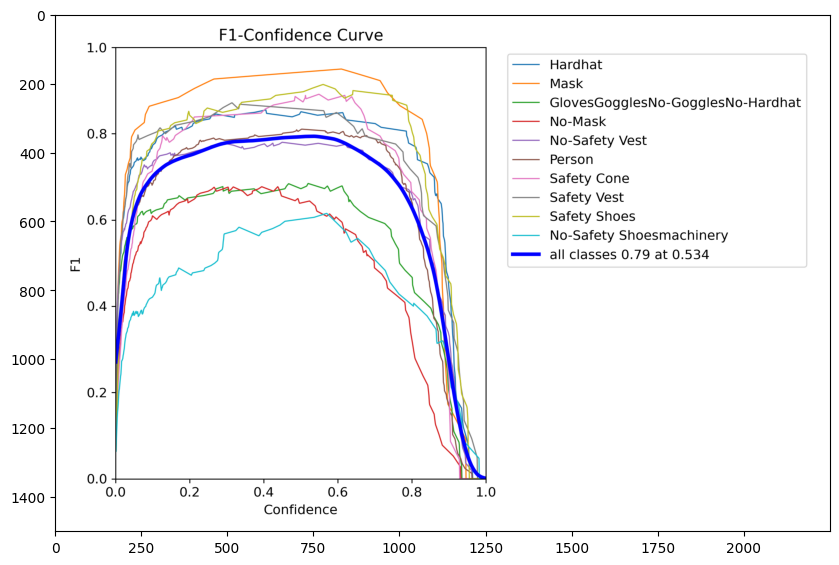



/content/css-data/test/images/ka_01181_png_jpg.rf.154ee4ef254eabd62e316be50470c578.jpg
Type: <class 'PIL.PngImagePlugin.PngImageFile'> 

Shape: (1500, 2250, 4)


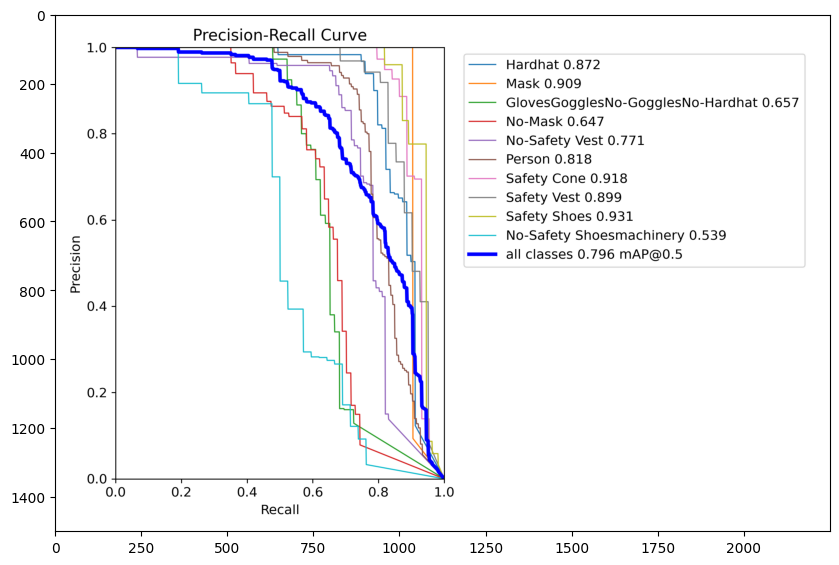



/content/css-data/test/images/ka_01181_png_jpg.rf.154ee4ef254eabd62e316be50470c578.jpg
Type: <class 'PIL.PngImagePlugin.PngImageFile'> 

Shape: (1500, 2250, 4)


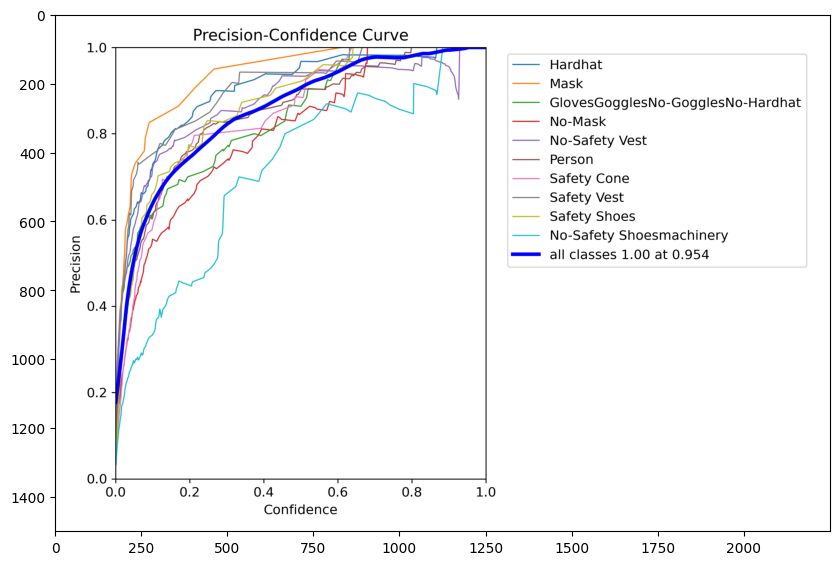



/content/css-data/test/images/ka_01181_png_jpg.rf.154ee4ef254eabd62e316be50470c578.jpg
Type: <class 'PIL.PngImagePlugin.PngImageFile'> 

Shape: (1500, 2250, 4)


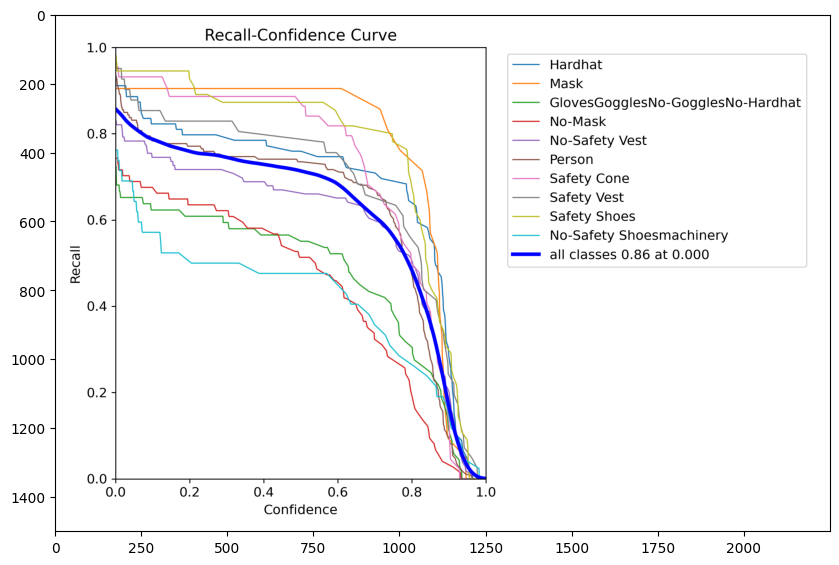



/content/css-data/test/images/ka_01181_png_jpg.rf.154ee4ef254eabd62e316be50470c578.jpg
Type: <class 'PIL.PngImagePlugin.PngImageFile'> 

Shape: (2250, 3000, 4)


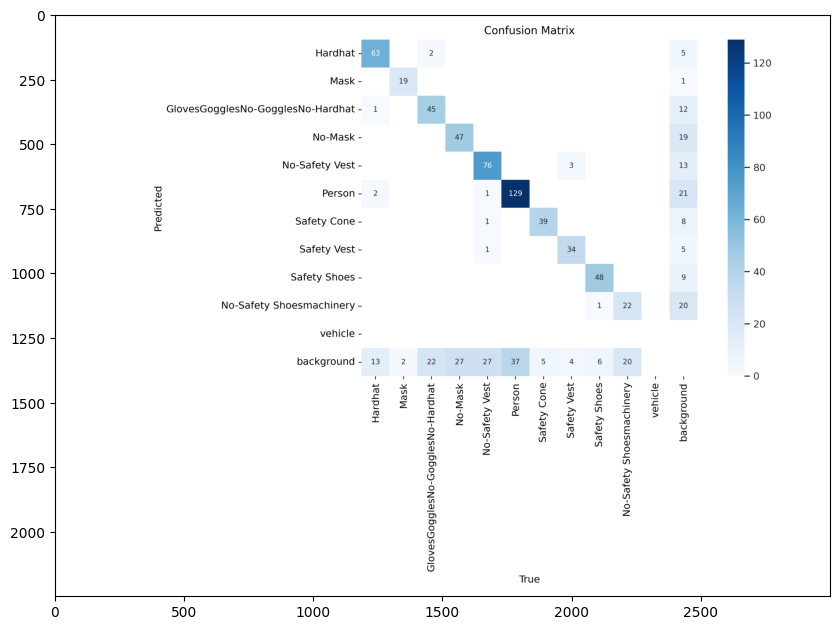



/content/css-data/test/images/ka_01181_png_jpg.rf.154ee4ef254eabd62e316be50470c578.jpg
Type: <class 'PIL.PngImagePlugin.PngImageFile'> 

Shape: (2250, 3000, 4)


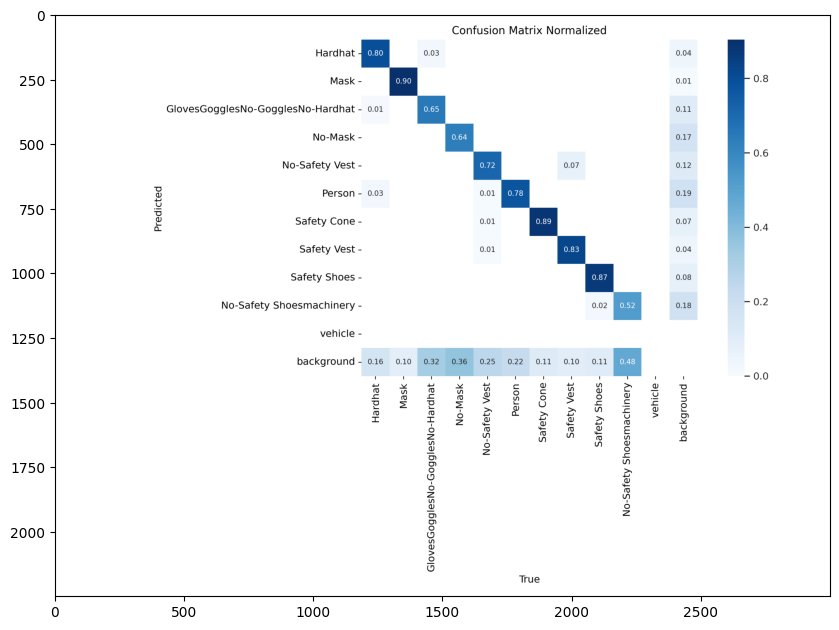



/content/css-data/test/images/ka_01181_png_jpg.rf.154ee4ef254eabd62e316be50470c578.jpg
Type: <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape: (1600, 1600, 3)


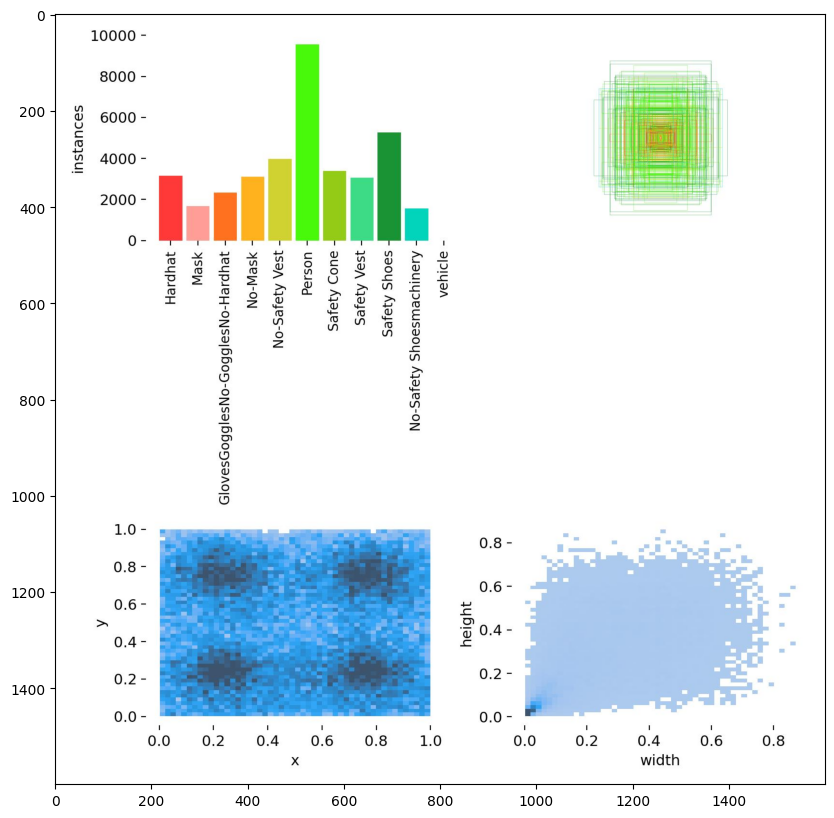



/content/css-data/test/images/ka_01181_png_jpg.rf.154ee4ef254eabd62e316be50470c578.jpg
Type: <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape: (2000, 2000, 3)


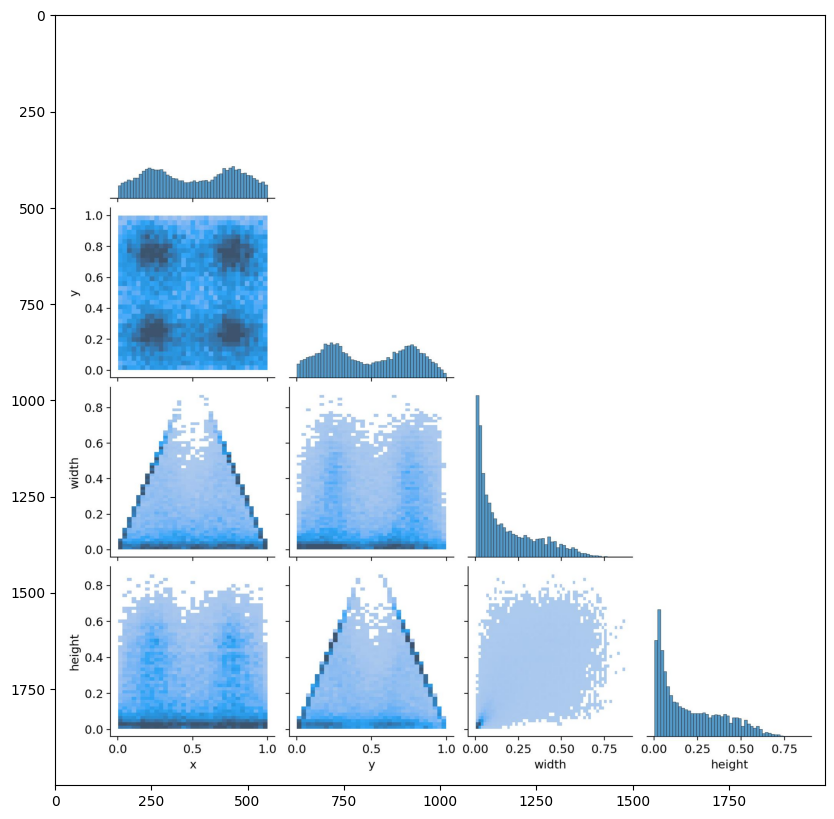



/content/css-data/test/images/ka_01181_png_jpg.rf.154ee4ef254eabd62e316be50470c578.jpg
Type: <class 'PIL.PngImagePlugin.PngImageFile'> 

Shape: (1200, 2400, 4)


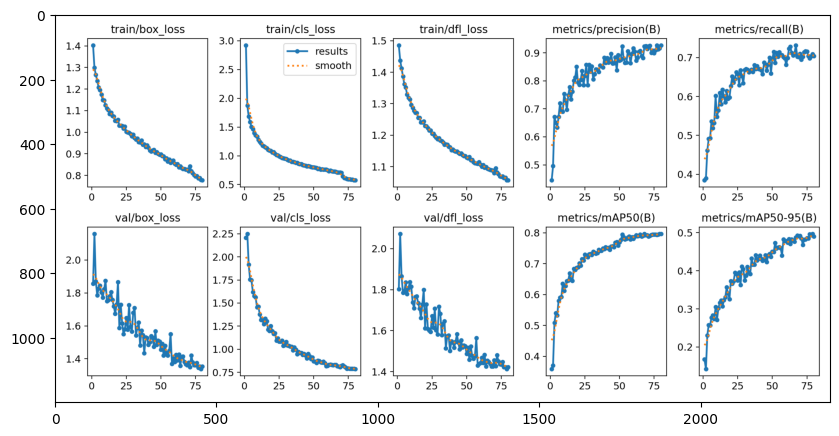

In [23]:
for image in sorted(evaluations):
  print(file)
  show_image(image_path=image, random_img=False)
  print('\n')

In [ ]:
dataframe = pd.read_csv(f'{OUTPUT_DIR}runs/detect/{BASE_MODEL}_{EXP_NAME}/results.csv')
dataframe = dataframe.rename(columns=lambda x: x.replace(" ", ""))
dataframe.to_csv(f'{OUTPUT_DIR}training_log_dataframe.csv', index=False)

In [25]:
dataframe.tail()

epoch  train/box_loss  train/cls_loss  train/dfl_loss  \
75     76         0.79717         0.59011          1.0697   
76     77         0.78633         0.58530          1.0644   
77     78         0.78766         0.58873          1.0654   
78     79         0.77868         0.57459          1.0573   
79     80         0.77751         0.57762          1.0568   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
75               0.90971            0.70386           0.79485   
76               0.92661            0.69855           0.79364   
77               0.91323            0.70300           0.79399   
78               0.91609            0.70944           0.79641   
79               0.92738            0.70410           0.79604   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
75              0.48529        1.3759       0.78972        1.4469  0.000048   
76              0.49625        1.3451       0.78890        1.4221  0.000040   
77              0.49320        1.3536       0.79016        1.4220  0.000031   
78              0.49670        1.3386       0.78773        1.4135  0.000023   
79              0.48982        1.3540       0.78705        1.4219  0.000015   

      lr/pg1    lr/pg2  
75  0.000048  0.000048  
76  0.000040  0.000040  
77  0.000031  0.000031  
78  0.000023  0.000023  
79  0.000015  0.000015

In [26]:
print('Best Training Box loss: ', dataframe['train/box_loss'].min(), ', on epoch: ', dataframe['train/box_loss'].argmin() + 1, '\n')
print('Best Validation Box loss: ', dataframe['val/box_loss'].min(), ', on epoch: ', dataframe['val/box_loss'].argmin() + 1, '\n')
print('Best Training Cls loss: ', dataframe['train/cls_loss'].min(), ', on epoch: ', dataframe['train/cls_loss'].argmin() + 1, '\n')
print('Best Validation Cls loss: ', dataframe['val/cls_loss'].min(), ', on epoch: ', dataframe['val/cls_loss'].argmin() + 1, '\n')
print('Best Training dataframeL loss: ', dataframe['train/dfl_loss'].min(), ', on epoch: ', dataframe['train/dfl_loss'].argmin() + 1, '\n')
print('Best Validation dataframeL loss: ', dataframe['val/dfl_loss'].min(), ', on epoch: ', dataframe['val/dfl_loss'].argmin() + 1, '\n')

Best Training Box loss:  0.77751 , on epoch:  80 

Best Validation Box loss:  1.3386 , on epoch:  79 

Best Training Cls loss:  0.57459 , on epoch:  79 

Best Validation Cls loss:  0.78705 , on epoch:  80 

Best Training dataframeL loss:  1.0568 , on epoch:  80 

Best Validation dataframeL loss:  1.4135 , on epoch:  79 



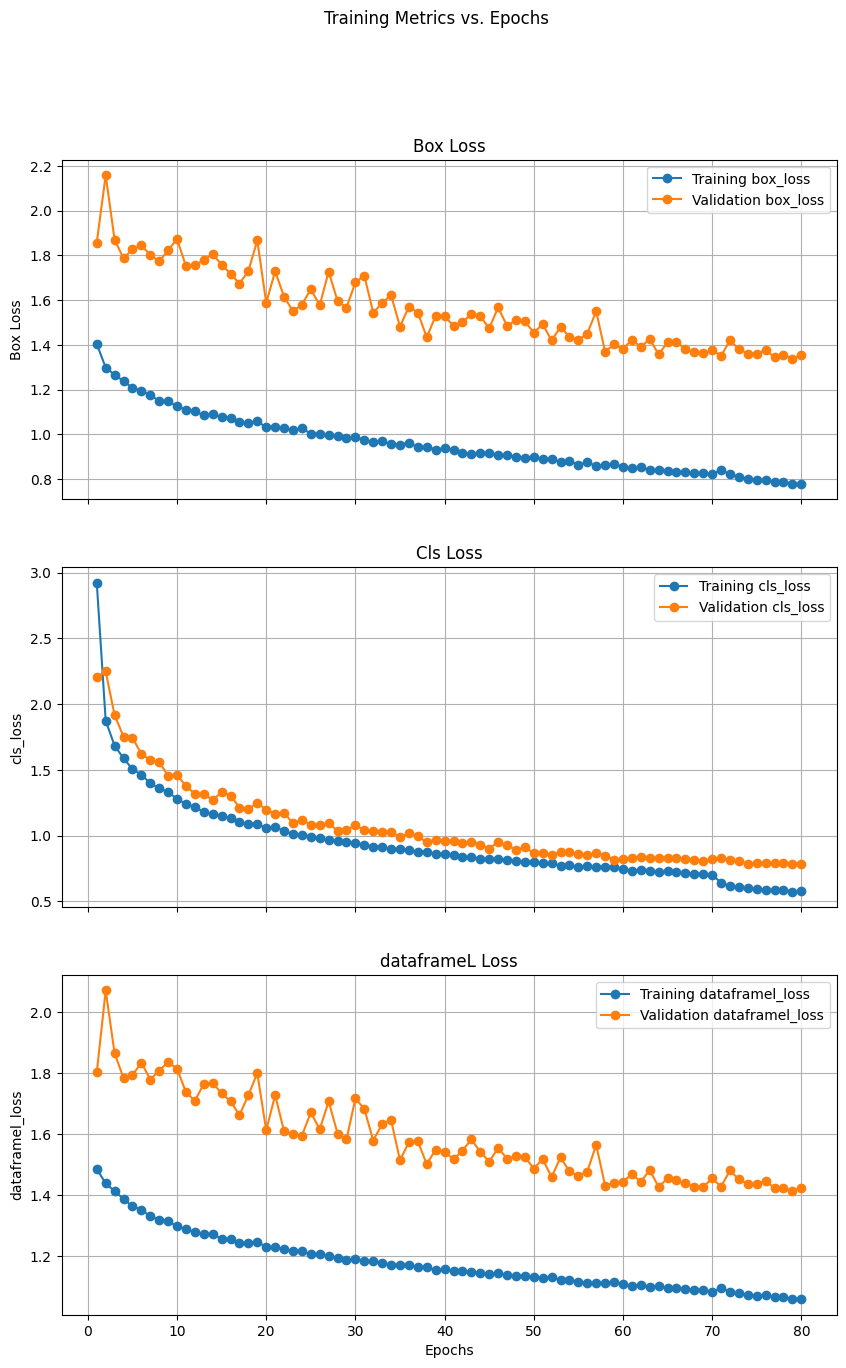

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
ax1.set_title('Box Loss')
ax1.plot(dataframe['epoch'], dataframe['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(dataframe['epoch'], dataframe['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

ax2.set_title('Cls Loss')
ax2.plot(dataframe['epoch'], dataframe['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(dataframe['epoch'], dataframe['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

ax3.set_title('dataframeL Loss')
ax3.plot(dataframe['epoch'], dataframe['train/dfl_loss'], label='Training dataframel_loss', marker='o', linestyle='-')
ax3.plot(dataframe['epoch'], dataframe['val/dfl_loss'], label='Validation dataframel_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dataframel_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

In [28]:
validation = [
    i for i in
    glob.glob(f'{OUTPUT_DIR}runs/detect/{BASE_MODEL}_{EXP_NAME}/*.png') +
    glob.glob(f'{OUTPUT_DIR}runs/detect/{BASE_MODEL}_{EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

print(len(validation))

6


/content/runs/detect/yolov8n_ppe_css_yolov8n_epochs/val_batch2_pred.jpg
Type: <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape: (1920, 1920, 3)


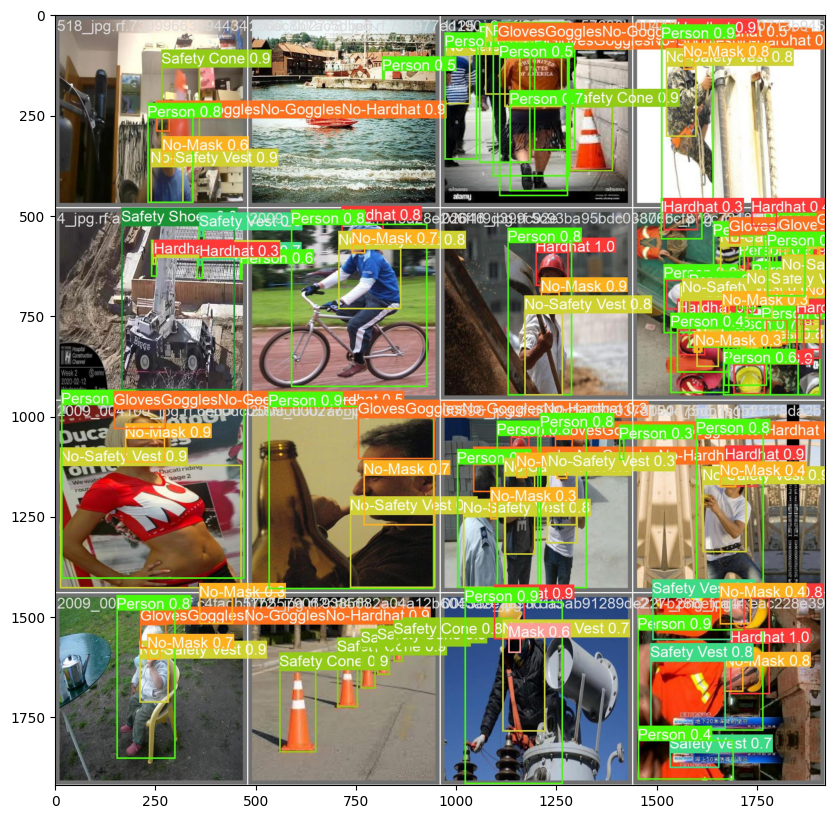

In [29]:
if len(validation) >= 1:
    val_img_path = random.choice(validation)
    print(val_img_path)
    show_image(val_img_path, random_img=False)